# Aim of the notebook

We explore the specificity of each SRT method by definnig a negative marker coexpression score (NCP),also refered as NMP through the pipeline. Explore the methods section of Marco Salas et al. 2024 for further details about this metric

# Read packages

In [1]:
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from anndata import AnnData
import sklearn
from scipy.sparse import issparse
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from xb.calculating import coexpression_calculation,negative_marker_purity_coexpression

# Define all previously ST preprocessed files

In [2]:
path = '../../figures/2.comparison_between_datasets/with_regional_anno_segmented/'
files=['anno_CosMx.h5ad', 'anno_Hybriss.h5ad', 'anno_MERFISH.h5ad','anno_ResolveBio.h5ad','anno_Vizgen.h5ad', 'anno_Xenium.h5ad']

Next we read he files and combine in the same file

In [3]:
adata_dict = {}
for file in files: 
    print(file)
    adata = sc.read(path+file)
    try:
        adata.X = adata.X.toarray()
    except: 
        print('nothing to format')
    adata.obs['x']=adata.obs['x_centroid']
    adata.obs['y']=adata.obs['y_centroid']
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    if file == 'anno_scRNAseq.h5ad':
        adata.var.index = adata.var.gene_symbol
    adata.var.index = adata.var.index.map(str.lower)
    adata_dict[file.split('.')[0]] = adata

anno_CosMx.h5ad
nothing to format
anno_Hybriss.h5ad
nothing to format
anno_MERFISH.h5ad
nothing to format
anno_ResolveBio.h5ad
nothing to format
anno_Vizgen.h5ad
nothing to format
anno_Xenium.h5ad
nothing to format


Then, we reread single cell data since we need the updated version and update it in the list of adatas

In [5]:
#reread single cell data since we need the updated version
adata_sc=sc.read('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/data/scRNAseq/WMB-10Xv2-subset02_ready_for_xenium_benchmark.h5ad')
gjn=adata_sc.var.groupby(adata_sc.var.index).count().sort_values(by='name')
adata_sc=adata_sc[:,adata_sc.var.index.isin(gjn.index[gjn['name']==1])]
adata_dict['anno_scRNAseq']=adata_sc
adata_dict['anno_scRNAseq'].var.index=adata_dict['anno_scRNAseq'].var['gene_symbol'].map(str.lower)
adata_dict['anno_scRNAseq'].obs['spatial annotation']=adata_dict['anno_scRNAseq'].obs['anatomical_division_label_x']

# We apply the NMP scores in the  cortex subset

In [6]:
cortical_clusters=['D: CTX','L1', 'L2/3', 'L4', 'L5' ,'L6a' ,'L6b','L1', 'L2/3', 'L4', 'L5' ,'L6a', 'L6b',
 'AUD1', 'AUD2' ,'AUD2/3', 'AUD4', 'AUD5', 'AUD6a', 'AUD6b',
 'MO1', 'MO2', 'MO2-3' ,'MO5','MO6a', 'MO6b','SSp1', 'SSp2', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a',
 'SSp6b','Isocortex','D: CTX','D: CTX [1]']

In [7]:
adata_sc = adata_sc[adata_sc.obs['anatomical_division_label_y'] == 'Isocortex']

In [8]:
files2=['anno_CosMx', 'anno_allen_smfish', 'anno_vizgen', 'anno_r1_multisection_Xenium', 'anno_starmap', 'anno_allen_merFISH', 'anno_baristaseq', 'anno_exseq', 'anno_Hybriss', 'anno_osmfish', 'anno_ResolveBio', 'anno_scRNAseq']

### By reading the calculated mean ratios(3_3), we can use them to filter only the genes with a ratio>1 for NMP calculation

In [41]:
df_con_cortex=pd.read_csv('../../figures/2.comparison_between_datasets/ratios_vs_sc/ratios_version_cortex_resegmented_segmentation.csv')

In [42]:
adata_sc=adata_dict['anno_scRNAseq']
adata_sc=adata_sc[adata_sc.obs['spatial annotation'].astype(str).isin(cortical_clusters)]

In [43]:
cortical_clusters=['D: CTX','L1', 'L2/3', 'L4', 'L5' ,'L6a' ,'L6b','L1', 'L2/3', 'L4', 'L5' ,'L6a', 'L6b',
 'AUD1', 'AUD2' ,'AUD2/3', 'AUD4', 'AUD5', 'AUD6a', 'AUD6b',
 'MO1', 'MO2', 'MO2-3' ,'MO5','MO6a', 'MO6b','SSp1', 'SSp2', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a',
 'SSp6b','Isocortex','D: CTX','Isocortex']

In [44]:
adata_sc.var.columns=['gene','name','comment']
gns=adata_sc.var.groupby('gene_symbol').count().sort_values(by='name')
selgenes=gns[gns['name']==1].index
glow=[g.lower() for g in selgenes]
adata_sc=adata_sc[:,adata_sc.var.index.isin(glow)]
adata_dict['anno_Xenium'].obs.loc[:,'spatial annotation']=[d.replace('D:','').replace('[1]','').replace(' ','') for d in  adata_dict['anno_Xenium'].obs.loc[:,'region_annotation']]
adata_dict['anno_Hybriss'].obs['spatial annotation']=adata_dict['anno_Hybriss'].obs['region_annotation']

In [45]:
files=['anno_CosMx', 'anno_Hybriss', 'anno_MERFISH', 'anno_ResolveBio', 'anno_Vizgen', 'anno_Xenium']

anno_CosMx
175
anno_CosMx
(13746, 175)
(193380, 175)
Index(['acta2', 'adgrg1', 'adgrl2', 'adgrl3', 'adora1', 'adora2a', 'adra1d',
       'adrb2', 'agtr1a', 'agtr1b',
       ...
       'sstr2', 'sulf2', 'synpr', 'tacr1', 'tle4', 'trem2', 'vip', 'vipr1',
       'vipr2', 'vtn'],
      dtype='object', length=175)
(193380, 175)


100%|████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 327.05it/s]


anno_Hybriss
39
anno_Hybriss
(11956, 39)
(193380, 39)
Index(['acta2', 'aldoc', 'calb2', 'calm2', 'cd24a', 'cnr1', 'crh', 'flt1',
       'foxj1', 'gad1', 'gad2', 'gfap', 'hexb', 'itpr2', 'lamp5', 'mbp',
       'mfge8', 'mrc1', 'npy', 'nrn1', 'pcp4', 'pdgfra', 'penk', 'plp1',
       'pthlh', 'pvalb', 'rorb', 'serpinf1', 'slc17a7', 'slc32a1', 'slc6a1',
       'sox10', 'sst', 'synpr', 'syt6', 'tac2', 'tbr1', 'vip', 'vtn'],
      dtype='object')
(193380, 39)


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 625.21it/s]


anno_MERFISH
118
anno_MERFISH
(4424, 118)
(193380, 118)
Index(['acta2', 'adamts2', 'adra1b', 'alk', 'aqp4', 'bcl11b', 'bdnf', 'blnk',
       'calb1', 'calb2',
       ...
       'thsd7a', 'tmem163', 'tox', 'trpc4', 'tshz2', 'unc13c', 'vip', 'vipr2',
       'vtn', 'wnt7b'],
      dtype='object', length=118)
(193380, 118)


100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 536.01it/s]


anno_ResolveBio
73
anno_ResolveBio
(12212, 73)
(193380, 73)
Index(['adamts2', 'aqp4', 'bcl11b', 'blnk', 'calb1', 'cartpt', 'ccn2', 'chat',
       'chodl', 'col24a1', 'csf1r', 'cspg4', 'cux2', 'cxcl14', 'deptor',
       'dkk3', 'egln3', 'egr2', 'fezf2', 'flt1', 'fos', 'foxp2', 'gad1',
       'gfap', 'htr3a', 'inpp4b', 'kit', 'lamp5', 'lhx6', 'lpl', 'man1a',
       'mog', 'nos1', 'nr4a2', 'ntsr1', 'nxph4', 'olig2', 'oprk1', 'otof',
       'pcp4', 'pde1a', 'pdgfra', 'pecam1', 'plp1', 'prox1', 'ptgs2', 'pthlh',
       'pvalb', 'rasgrf2', 'rbfox3', 'reln', 'rora', 'rorb', 'rspo1', 'satb2',
       'slc17a7', 'slc17a8', 'snap25', 'sncg', 'sox10', 'spi1', 'sst', 'syt6',
       'tacr1', 'tbr1', 'th', 'tle4', 'tox', 'trem2', 'trhr', 'tshz2', 'vip',
       'wnt7b'],
      dtype='object')
(193380, 73)


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 458.89it/s]


anno_Vizgen
125
anno_Vizgen
(12928, 125)
(193380, 125)
Index(['adgrg1', 'adgrl2', 'adgrl3', 'adgrl4', 'adora1', 'adora2a', 'adra1b',
       'adra1d', 'adrb2', 'agtr1a',
       ...
       'slc17a8', 'slc32a1', 'sox9', 'sstr1', 'sstr2', 'tacr1', 'th', 'trhr',
       'vipr1', 'vipr2'],
      dtype='object', length=125)
(193380, 125)


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 385.21it/s]


anno_Xenium
111
anno_Xenium
(33264, 111)
(193380, 111)
Index(['acta2', 'adamts2', 'adgrl4', 'aqp4', 'bcl11b', 'bdnf', 'calb1',
       'calb2', 'cbln4', 'ccn2',
       ...
       'tacr1', 'th', 'thsd7a', 'tle4', 'tmem163', 'tox', 'trem2', 'trpc4',
       'unc13c', 'vip'],
      dtype='object', length=111)
(193380, 111)


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 215.20it/s]


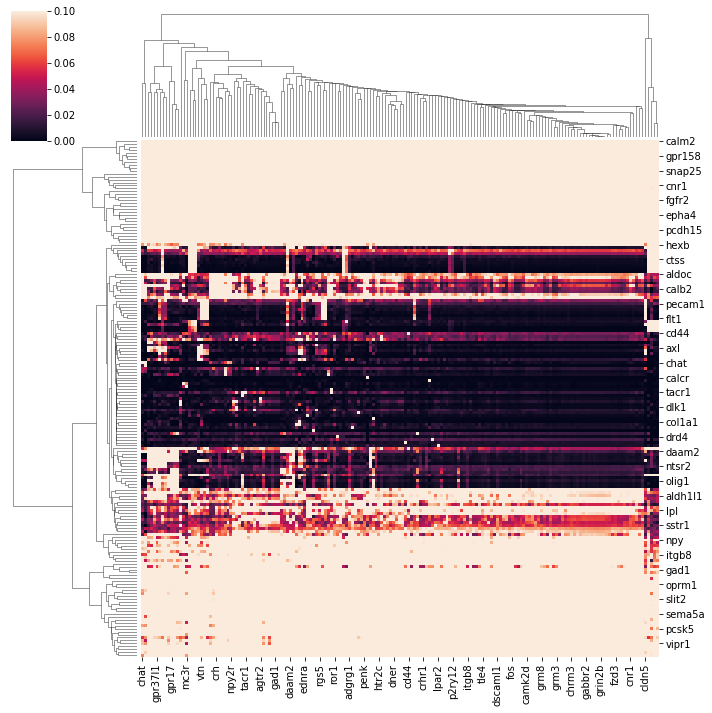

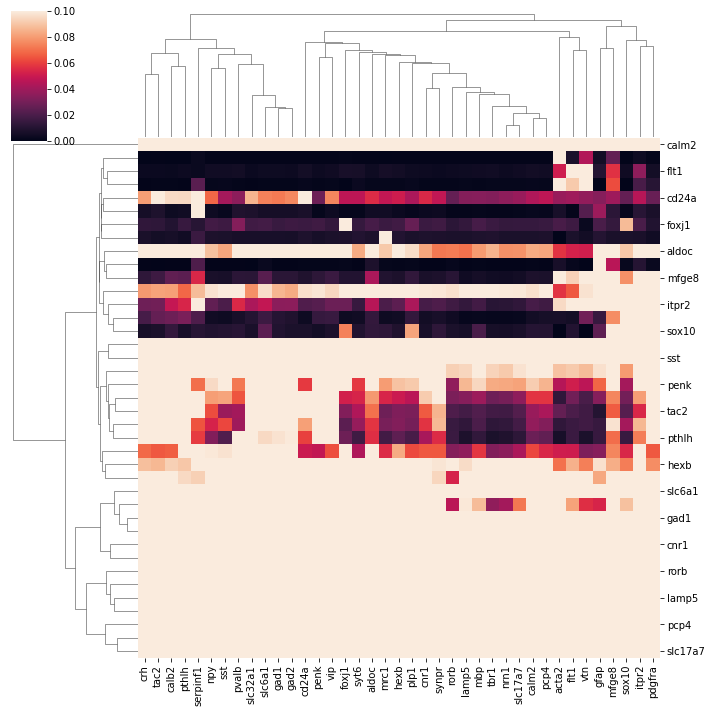

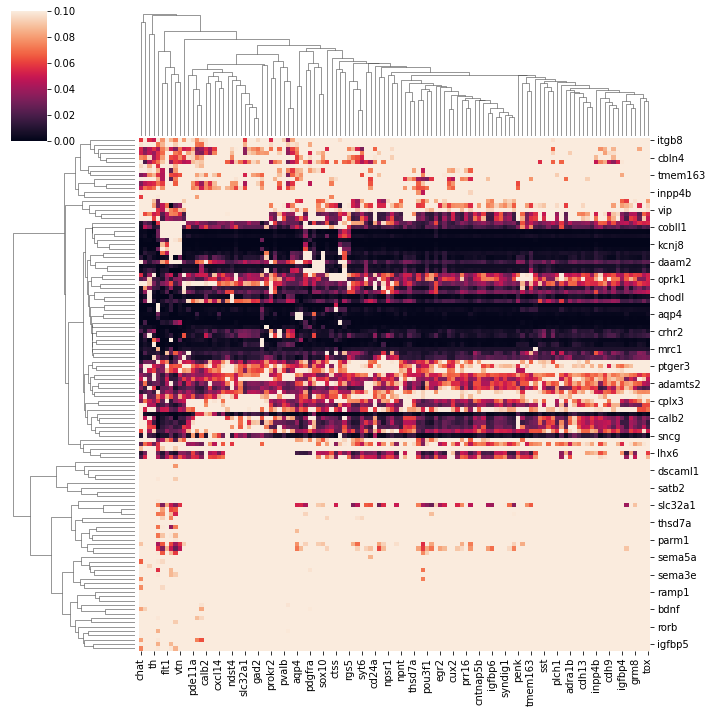

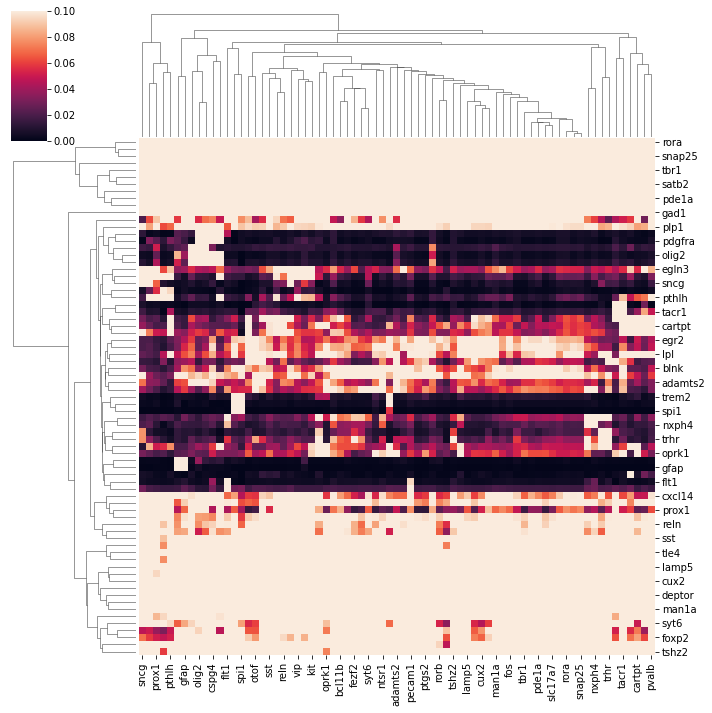

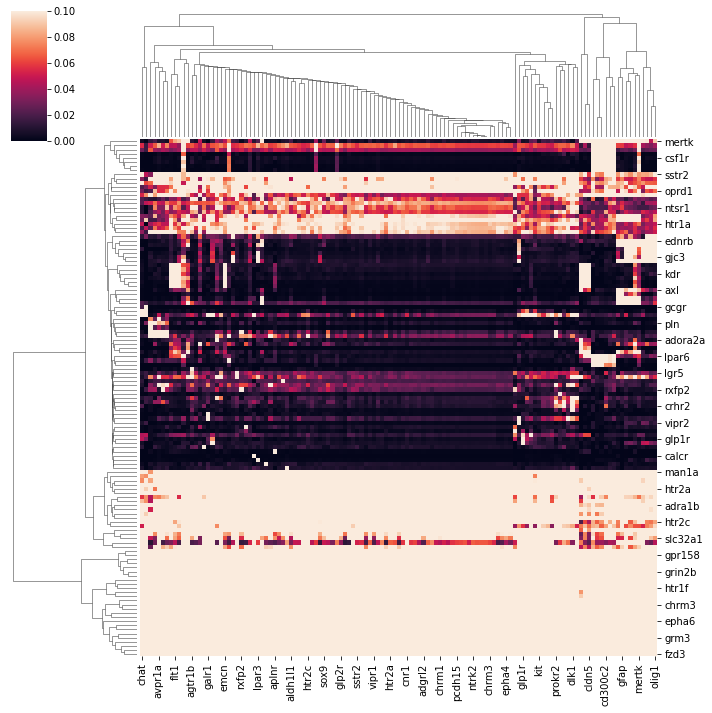

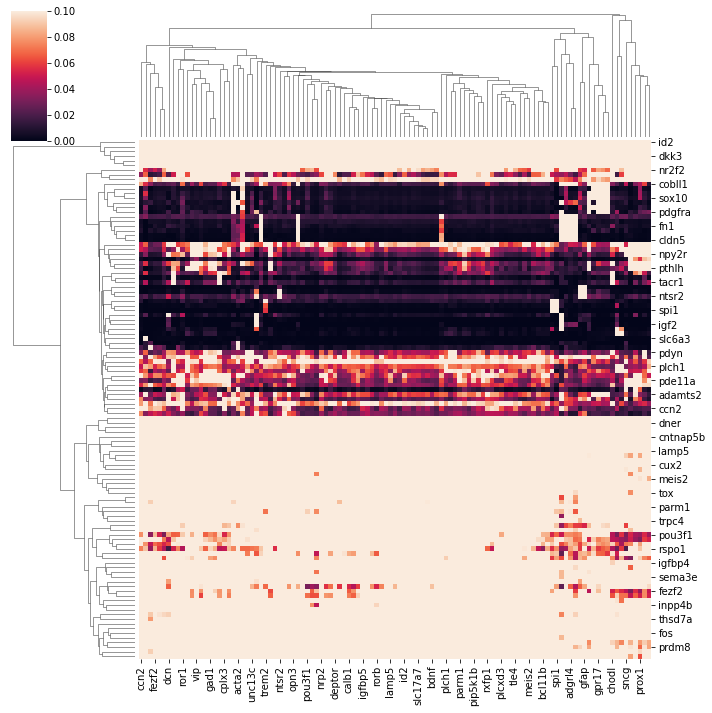

In [46]:
df_purity=pd.DataFrame()
df_ratio=pd.DataFrame()
purity_scores=[]
for fl in files:
    print(fl)
    adata_sp=adata_dict[fl]
    method=fl.split('anno_')[1]
    if method=='r1_multisection_Xenium':
        method='Xenium'
    dfilt=df_con_cortex[df_con_cortex['method']==method]
    dfilt=dfilt[dfilt['ratio']<10]
    adata_sp=adata_sp[:,adata_sp.var.index.isin(dfilt['gene'])]
    adata_sp=adata_sp[adata_sp.obs['spatial annotation'].astype(str).isin(cortical_clusters)]
    adata_sp.var_names=[x.lower() for x in adata_sp.var_names]
    adata_sc.var_names=[x.lower() for x in adata_sc.var_names]
    print(np.sum(adata_sp.var_names.isin(adata_sc.var_names)))
    if np.sum(adata_sp.var_names.isin(adata_sc.var_names))>10:
        print(fl)
        negative_marker_purity, purity_per_gene, purity_per_celltype,lowvals_sc,lowvals_sp,commongenes=negative_marker_purity_coexpression(adata_sp, adata_sc,pipeline_output=False)
        pur=pd.DataFrame(purity_per_celltype)
        for pr in pur.index:
            df_purity.loc[fl,pr]=pur.loc[pr,0]
    else:
        print(fl+' not possible')

In [47]:
purity_overall=pd.DataFrame(1-np.nanmean(df_purity,axis=1),index=df_purity.index)
df_purity_filt=1-df_purity#.loc[:,np.sum(df_purity>0,axis=0)>2]

In [48]:
gnall=[]
dsall=[]
vall=[]
for gn in  df_purity_filt.index:
    for ds in  df_purity_filt.columns:
        if df_purity_filt.loc[gn,ds]>0:
            vall.append(df_purity_filt.loc[gn,ds])
            gnall.append(gn)
            dsall.append(ds)

In [49]:
summary_of_results=pd.DataFrame([gnall,vall,dsall],index=['method','purity','gene']).transpose()

We define color for each specific method

In [50]:
color_dicitonary = {'anno_scRNAseq': 'black','anno_starmap': 'red', 'anno_allen_smfish': 'purple',
 'anno_MERFISH': '#9EE493',   'anno_Hybriss': '#e82a92','anno_osmfish': 'yellow',
 'anno_exseq': 'brown', 'anno_Vizgen': '#2E5077', 'anno_baristaseq': 'orange', 'anno_Xenium':'#56018f',
'anno_ResolveBio':'#4DA1A9', 'anno_CosMx':'#FFA630'}

In [51]:
sumu=summary_of_results.loc[:,['method','purity']].groupby('method').median()
order=sumu.sort_values(by='purity').index
summary_of_results['color']=summary_of_results['method'].map(color_dicitonary)
coli=[color_dicitonary[el] for el in order]

# We plot the purity score (NCP/NMP) for each gene

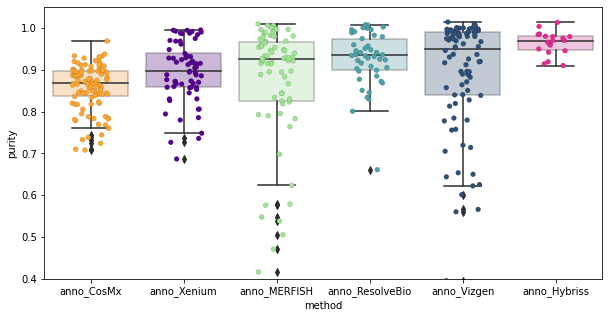

In [53]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
with plt.rc_context({'figure.figsize': (10, 5)}):
    sns.boxplot(x="method", y="purity",order=order, data=summary_of_results, palette=coli, boxprops=dict(alpha=.3))
    sns.stripplot(x="method", y="purity",edgecolor='black',order=order,
            linewidth=0.09, jitter=0.2,
             # colormap="Set3",# order=clarity_ranking,
               data=summary_of_results, palette=coli)
    plt.ylim([0.4,1.05])
    plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/NegMarkerPurity_cortex_resegmented_segmentation_all.pdf')

In [56]:
summary_of_results

,method,purity,gene,color,uni_id
0,CosMx,0.889359,acta2,#FFA630,CosMx_acta2
1,CosMx,0.805741,adgrg1,#FFA630,CosMx_adgrg1
2,CosMx,0.871134,adora2a,#FFA630,CosMx_adora2a
3,CosMx,0.710009,adra1d,#FFA630,CosMx_adra1d
4,CosMx,0.89706,adrb2,#FFA630,CosMx_adrb2
...,...,...,...,...,...
392,Xenium,0.918238,cd300c2,#56018f,Xenium_cd300c2
393,Xenium,0.830387,gjc3,#56018f,Xenium_gjc3
394,Xenium,0.867137,opn3,#56018f,Xenium_opn3
395,Xenium,0.97015,pln,#56018f,Xenium_pln


In [60]:
merged_info2=merged_info[merged_info['ratio']<1.1]

In [66]:
merged_info2

,Unnamed: 0,ratio,method_x,gene_x,color_x,uni_id,method_y,purity,gene_y,color_y
0,0,0.583333,MERFISH,oprk1,#9EE493,MERFISH_oprk1,MERFISH,1.000987,oprk1,#9EE493
1,7,0.514706,MERFISH,tmem163,#9EE493,MERFISH_tmem163,MERFISH,0.956185,tmem163,#9EE493
3,9,0.785311,MERFISH,prox1,#9EE493,MERFISH_prox1,MERFISH,0.914658,prox1,#9EE493
4,10,0.929412,MERFISH,mrc1,#9EE493,MERFISH_mrc1,MERFISH,0.883132,mrc1,#9EE493
6,14,1.000000,MERFISH,cobll1,#9EE493,MERFISH_cobll1,MERFISH,0.989761,cobll1,#9EE493
...,...,...,...,...,...,...,...,...,...,...
389,158,0.974638,CosMx,csf1r,#FFA630,CosMx_csf1r,CosMx,0.851531,csf1r,#FFA630
393,162,1.098870,CosMx,galr1,#FFA630,CosMx_galr1,CosMx,0.885905,galr1,#FFA630
394,169,0.398148,CosMx,acta2,#FFA630,CosMx_acta2,CosMx,0.889359,acta2,#FFA630
395,171,1.098684,CosMx,agtr2,#FFA630,CosMx_agtr2,CosMx,0.868081,agtr2,#FFA630


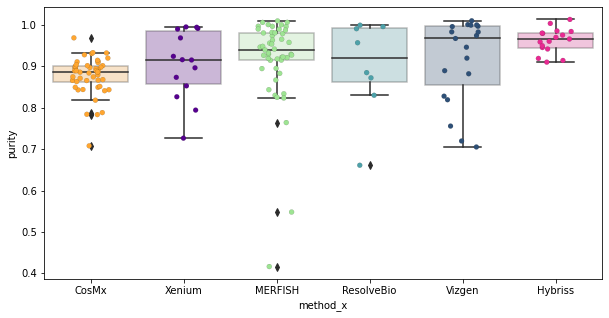

In [82]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
with plt.rc_context({'figure.figsize': (10, 5)}):
    sns.boxplot(x="method_x", y="purity",order=order2, data=merged_info2, palette=coli, boxprops=dict(alpha=.3))
    sns.stripplot(x="method_x", y="purity",edgecolor='black',order=order2,
            linewidth=0.09, jitter=0.2,data=merged_info2, palette=coli)
#    plt.ylim([0.4,1.05])
    plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/NegMarkerPurity_cortex_resegmented_segmentation.pdf')

# We plot detection efficiency agains specificity

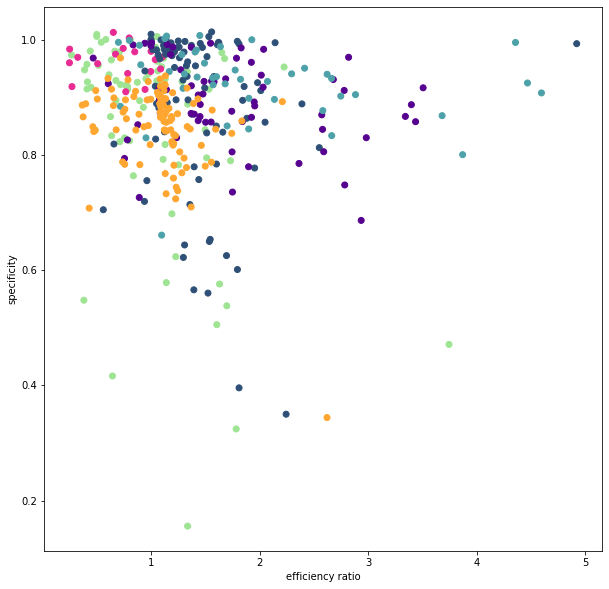

In [71]:
summary_of_results['method']=[el.replace('anno_','') for el in summary_of_results['method']]
df_con_cortex['uni_id']=df_con_cortex['method']+'_'+df_con_cortex['gene']
summary_of_results['uni_id']=summary_of_results['method']+'_'+summary_of_results['gene']
merged_info=df_con_cortex.merge(summary_of_results,on='uni_id')

#plot
plt.figure(figsize=(10,10))
plt.scatter(merged_info['ratio'],merged_info['purity'],c=merged_info['color'])
plt.xlabel('efficiency ratio')
plt.ylabel('specificity')
plt.savefig('../../figures/2.comparison_between_datasets/ratios_vs_sc/specificity_vs_efficiency_scatter_cortex.pdf')